In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import os
import hiplot as hip
from pickle import load
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pickle
import shap
import sys
sys.path.append('../')
from utils import *

## Función para sacar las figuras de Shap de todas las notas z y deciles

In [2]:
def shap_summary_plots( year, periodo):

    #Data directory
    data_dir = "../../data/unziped_data/"

    #Open data parsing with CSV
    data_for_training = "../../data/Data_For_Training/"
    
    # Read data_training
    df_training = pd.read_csv(data_for_training+"icfes_{0}{1}.csv".format(year,periodo))

    
    # lista de las columnas con las caracteristicas a predecir
    notasz = [c for c in df_training.columns.values if c.startswith("NOTA_Z")]
    deciles = [c for c in df_training.columns.values if c.startswith("DECILE")]
    labels_names = notasz + deciles

    # lista de las columnas que se van a omitir de las caracteristicas
    vars_2_omit = (
        [
        "PUNT_LECTURA_CRITICA",
        "PERCENTIL_LECTURA_CRITICA",
        "DESEMP_LECTURA_CRITICA",
        "PUNT_MATEMATICAS",
        "PERCENTIL_MATEMATICAS",
        "DESEMP_MATEMATICAS",
        "PUNT_C_NATURALES",
        "PERCENTIL_C_NATURALES",
        "DESEMP_C_NATURALES",
        "PUNT_SOCIALES_CIUDADANAS",
        "PERCENTIL_SOCIALES_CIUDADANAS",
        "DESEMP_SOCIALES_CIUDADANAS",
        "PUNT_INGLES",
        "PERCENTIL_INGLES",
        "DESEMP_INGLES",
        "PUNT_GLOBAL",
        "PERCENTIL_GLOBAL",
        ]
        + deciles
        + notasz
    )

    labels = df_training[labels_names]
    features = df_training.drop(vars_2_omit, axis=1)
    
    scaler_features = load(open("models/scaler_features_20181.pkl", "rb"))
    
    new_features = scaler_features.transform(features)
    features = pd.DataFrame(data=new_features, columns=features.columns)

    
    for ln in notasz:
        print(ln)
        model = upload_xgb_model(ln, year, periodo)

        #Shap implementation of model
        explainer = shap.TreeExplainer(model)

        #Upload data that model use for training
        shap_values = explainer.shap_values(features)

        #shap.force_plot(explainer.expected_value, shap_values[0,:], features.iloc[0,:])
        shap.summary_plot(shap_values, features,plot_type="bar")
        shap.summary_plot(shap_values, features)
        
    
    for ln in deciles:
        print(ln)
        model = upload_xgb_model(ln, year, periodo)

        #Shap implementation of model
        explainer = shap.TreeExplainer(model)

        #Upload data that model use for training
        shap_values = explainer.shap_values(features)

        #shap.force_plot(explainer.expected_value, shap_values[0,:], features.iloc[0,:])
        shap.summary_plot(shap_values, features,plot_type="bar")
        shap.summary_plot(shap_values, features)
    

In [3]:
shap_summary_plots(2018, 2)

Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.


RuntimeError: The reset parameter is False but there is no n_features_in_ attribute. Is this estimator fitted?

In [127]:
def dict_to_list(dictionary):
    keys = []
    scores_keys=[]
    for element in dictionary:
        keys.append(element)
        scores_keys.append(dictionary[element])
    return keys, scores_keys

def bars_plot_scores(ln, N, score):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    keys, scores_keys = dict_to_list(score[ln])
    data = pd.DataFrame({"Variables más Importantes":keys[:N],"Score":scores_keys[:N]},)
    
    sns.barplot(x="Variables más Importantes", y="Score", data=data,palette="Blues_d",linewidth=2.5 )
    sns.set_style("whitegrid")
    plt.xticks(fontsize=11,rotation=15, horizontalalignment='right')
    plt.yticks(fontsize=11)
    plt.xlabel("Variables más Importantes",fontsize=15)
    plt.ylabel("Score",fontsize=15)
    
    plt.show()    
    return keys

## Función para sacar histogramas tradicionales con el score de XGboost

In [128]:
def histograms_all(year,periodo):
    #Data directory
    data_dir = "../../data/unziped_data/"

    #Open data parsing with CSV
    data_for_training = "../../data/Data_For_Training/"
    
    # Read data_training
    df_training = pd.read_csv(data_for_training+"icfes_{0}{1}.csv".format(year,periodo))
  
    # lista de las columnas con las caracteristicas a predecir
    notasz = [c for c in df_training.columns.values if c.startswith("NOTA_Z")]
    deciles = [c for c in df_training.columns.values if c.startswith("DECILE")]
    labels_names = notasz + deciles

    # lista de las columnas que se van a omitir de las caracteristicas
    vars_2_omit = (
        [
        "PUNT_LECTURA_CRITICA",
        "PERCENTIL_LECTURA_CRITICA",
        "DESEMP_LECTURA_CRITICA",
        "PUNT_MATEMATICAS",
        "PERCENTIL_MATEMATICAS",
        "DESEMP_MATEMATICAS",
        "PUNT_C_NATURALES",
        "PERCENTIL_C_NATURALES",
        "DESEMP_C_NATURALES",
        "PUNT_SOCIALES_CIUDADANAS",
        "PERCENTIL_SOCIALES_CIUDADANAS",
        "DESEMP_SOCIALES_CIUDADANAS",
        "PUNT_INGLES",
        "PERCENTIL_INGLES",
        "DESEMP_INGLES",
        "PUNT_GLOBAL",
        "PERCENTIL_GLOBAL",
        ]
        + deciles
        + notasz
    )

    labels = df_training[labels_names]
    features = df_training.drop(vars_2_omit, axis=1)
    
    bins=12

    print('Aquí empiezan las gráficas de score Nota Z')
    score = {}
    for label in notasz:
        score[label] = Calculate_and_sort_scores(label,features,year,periodo)
        keys = bars_plot_scores(label, 5, score)
        print(keys[:5])
        
        fig, ax = plt.subplots(1, len(keys[:5]), sharex=True, figsize=(20,6))
        counter = 0
        
        for k in keys[:5]:
            mask  = df_training[k].values == 1
            df_con = df_training[mask]
            df_sin = df_training[~mask]
            
            ax[counter].hist(df_con[label].values, bins, alpha=0.7, label=k)
            ax[counter].hist(df_sin[label].values, bins, alpha=0.7, label="NO-"+k)
            ax[counter].set(xlabel=label)
            ax[counter].legend(loc='upper right')
            counter +=1
        
        plt.show()
            
        
    
    print('Aquí empiezan las gráficas de score deciles')
    score_DECILE = {}
    for label in deciles:
        score_DECILE[label] = Calculate_and_sort_scores(label, features,year,periodo)
        keys = bars_plot_scores(label, 5, score_DECILE)
        print(keys[:5])
        

        fig, ax = plt.subplots(1, len(keys[:5]),sharex=True, figsize=(20,6))
        counter = 0
        for k in keys[:5]:
            mask  = df_training[k].values == 1
            df_con = df_training[mask]
            df_sin = df_training[~mask]
            
            ax[counter].hist(df_con[label].values, bins, alpha=0.7, label=k)
            ax[counter].hist(df_sin[label].values, bins, alpha=0.7, label="NO-"+k)
            ax[counter].set(xlabel=label)
            ax[counter].legend(loc='upper right')
            counter +=1
        fig.show()
    
    
    features_si_no = ['FAMI_EDUCACIONPADRE_Postgrado','FAMI_TIENEINTERNET','COLE_CALENDARIO_B']
    
    #for variable in features_si_no:
        
     #   mask  = df_training[variable].values == 1
      #  df_con = df_training[mask]
       # df_sin = df_training[~mask]
        
        #for label in notasz:
        #    plt.hist(df_con[label].values, bins, alpha=0.7, label=variable)
        #    plt.hist(df_sin[label].values, bins, alpha=0.7, label=variable)
        #    plt.legend(loc='upper right')
        #    plt.xlabel(label)
        #    plt.show()


Aquí empiezan las gráficas de score Nota Z


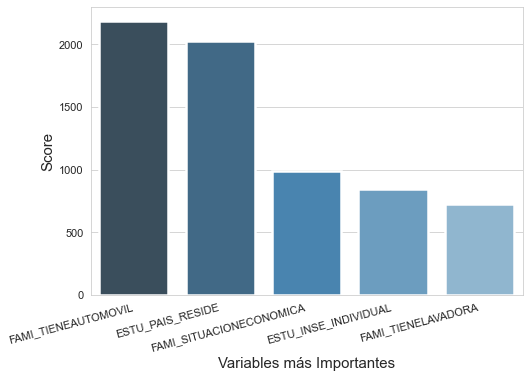

['FAMI_TIENEAUTOMOVIL', 'ESTU_PAIS_RESIDE', 'FAMI_SITUACIONECONOMICA', 'ESTU_INSE_INDIVIDUAL', 'FAMI_TIENELAVADORA']


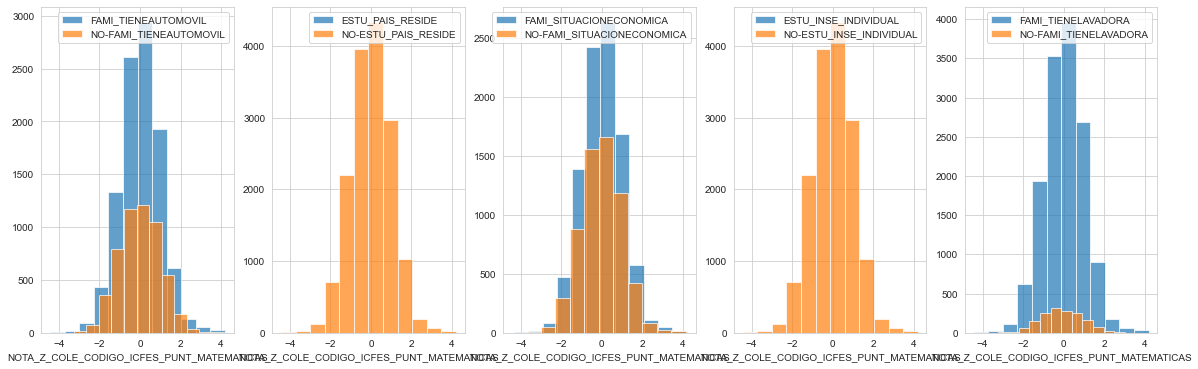

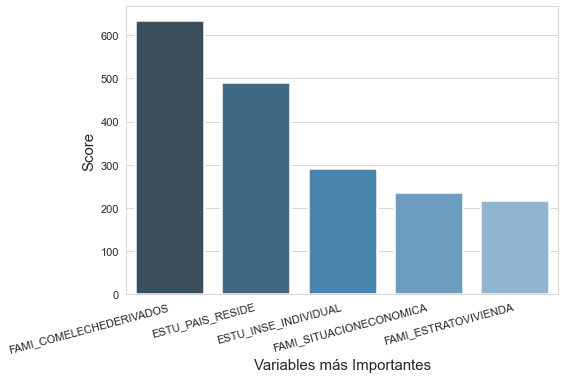

['FAMI_COMELECHEDERIVADOS', 'ESTU_PAIS_RESIDE', 'ESTU_INSE_INDIVIDUAL', 'FAMI_SITUACIONECONOMICA', 'FAMI_ESTRATOVIVIENDA']


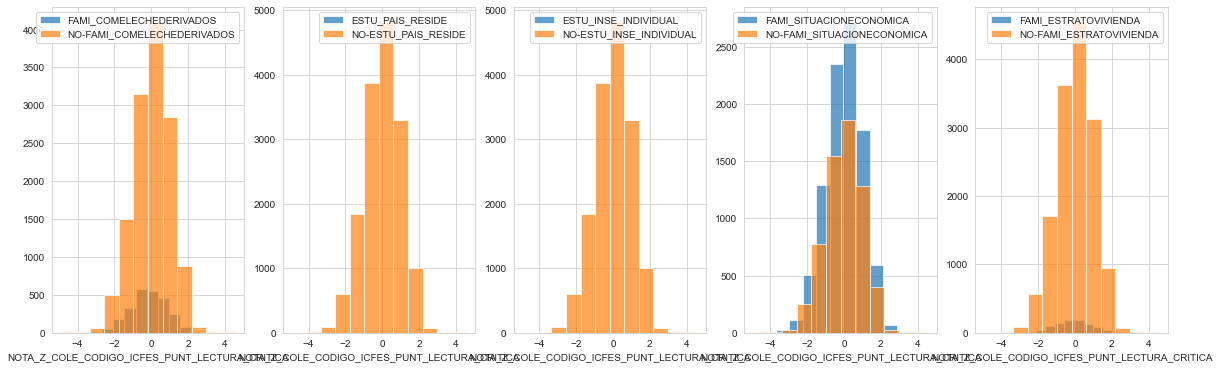

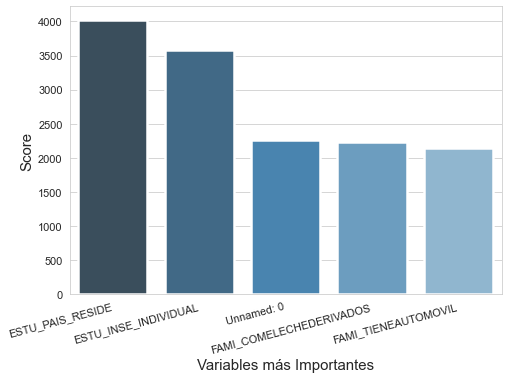

['ESTU_PAIS_RESIDE', 'ESTU_INSE_INDIVIDUAL', 'Unnamed: 0', 'FAMI_COMELECHEDERIVADOS', 'FAMI_TIENEAUTOMOVIL']


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x12a5c3bf8>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/transforms.py", line 177, in <lambda>
    ref = weakref.ref(self, lambda ref, sid=id(self),
KeyboardInterrupt


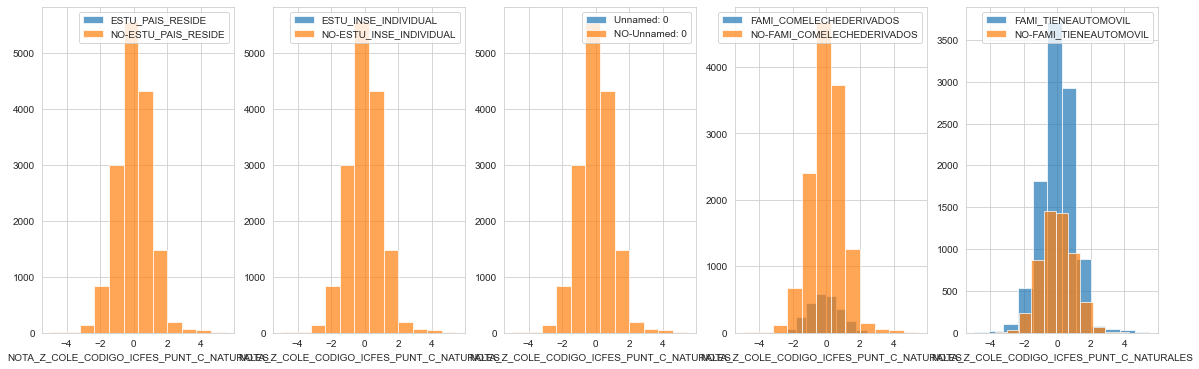

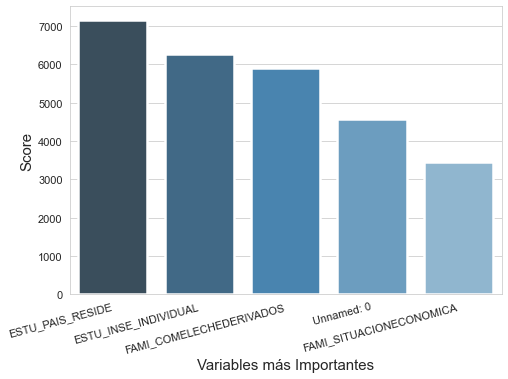

['ESTU_PAIS_RESIDE', 'ESTU_INSE_INDIVIDUAL', 'FAMI_COMELECHEDERIVADOS', 'Unnamed: 0', 'FAMI_SITUACIONECONOMICA']


KeyboardInterrupt: 

In [129]:
histograms_all(2018,2)